In [266]:
# import packages
import nfl_data_py as nfl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse

sns.set_theme(style='whitegrid')

In [136]:
# set flag for which metric we are calibrating LR with
# possible values are 'point diff', 'point ratio', 'pythagorean point ratio', 'dsr', 
# 'game control', 'game control signed', 'game control avg', 'game control fourth'
METRIC = 'game control fourth'

In [137]:
# create dataframe containing home team, away team, point differential (home - away, 0 if OT)
games = nfl.import_schedules([2022, 2021, 2019, 2018, 2017, 2016, 2015])
games.dropna(axis=0)
games['home_team'].replace({'SD': 'LAC', 'OAK': 'LV', 'STL': 'LA'}, inplace=True)
games['away_team'].replace({'SD': 'LAC', 'OAK': 'LV', 'STL': 'LA'}, inplace=True)
games['result'] = [0 if row['overtime'] else row['result'] for (index, row) in games.iterrows()] # replace overtime scores with 0

# merge ingame_stats dataframe
ingame_stats = pd.read_csv('data/ingame_stats.csv')
games = games.merge(ingame_stats, 'inner', ['game_id', 'home_team', 'away_team'])

nfldata = games[games['season'] != 2022][[
    'away_team', 'home_team', 'away_score', 'home_score', 'total', 'result', 'overtime', 'div_game', 'game_type', 'season', 'gameday',
    'home_dsr', 'away_dsr', 'home_gc', 'away_gc', 'home_gc_signed', 'away_gc_signed', 'home_gc_avg', 'away_gc_avg', 
    'home_gc_fourthqtr', 'away_gc_fourthqtr'
    ]]
# throw out final week games?

# plt.hist(nfldata['result'], bins=len(set(nfldata['result'])))
# plt.xticks(range(-39, 40, 3), fontsize=8, rotation=90) # how were plots generated in paper?

In [138]:
# extract all home-and-home matchups
# is only using divisional matchups hurting us? divisional rivalries tend to be more of a tossup than other games
# use all games where met in reg season and playoffs and home field switched in playoffs?

hah_games = nfldata.loc[(nfldata['div_game'] == 1) & (nfldata['game_type'] == 'REG')] # get all regular season divisional games

hah_games['series'] = [
    "".join(sorted([row[1]['home_team'], row[1]['away_team'], str(row[1]['season'])]))
    for row in hah_games.iterrows()] # isolate home-and-home pairs

hah_games.sort_values(['series', 'gameday'], inplace=True) # sort values so home team in i is away team in i+1

/var/folders/rw/8nrh1lbs5ngckj4mh93mhzv00000gn/T/ipykernel_55084/3441324046.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hah_games['series'] = [
/var/folders/rw/8nrh1lbs5ngckj4mh93mhzv00000gn/T/ipykernel_55084/3441324046.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hah_games.sort_values(['series', 'gameday'], inplace=True) # sort values so home team in i is away team in i+1


In [139]:
# store home-and-home game data in the form [home - away in first matchup, 0 or 1 whether differential negative in second matchup]
# home team from first matchup won iff (home - away) is negative in the second matchup
# probability of outscoring team in points in next matchup or outscoring based on that metric?

match METRIC:
    case 'point diff':
        outcomes = [row['result'] for (index, row) in hah_games.reset_index().iloc[::2,:].iterrows()]
    case 'point ratio':
        outcomes = [row['home_score'] / row['total'] for (index, row) in hah_games.reset_index().iloc[::2,:].iterrows()]
    case 'pythagorean point ratio':
        outcomes = [row['home_score']**2 / (row['home_score']**2 + row['away_score']**2) 
        for (index, row) in hah_games.reset_index().iloc[::2,:].iterrows()]
    case 'dsr':
        outcomes = [row['home_dsr'] - row['away_dsr'] for (index, row) in hah_games.reset_index().iloc[::2,:].iterrows()]
    case 'game control':
        outcomes = [row['home_gc'] for (index, row) in hah_games.reset_index().iloc[::2,:].iterrows()]
    case 'game control signed':
        outcomes = [row['home_gc_signed'] for (index, row) in hah_games.reset_index().iloc[::2,:].iterrows()]
    case 'game control avg':
        outcomes = [row['home_gc_avg'] for (index, row) in hah_games.reset_index().iloc[::2,:].iterrows()]
    case 'game control fourth':
        outcomes = [row['home_gc_fourthqtr'] for (index, row) in hah_games.reset_index().iloc[::2,:].iterrows()]

logr_X = np.array(outcomes)
logr_y = np.array([int(row['result'] < 0) for (index, row) in hah_games.reset_index().iloc[1::2, :].iterrows()])

In [140]:
# train logistic regression on home-and-home matchup data (prob. of original home team winning away in next matchup)
clf = LogisticRegression().fit(logr_X.reshape(-1, 1), logr_y.reshape(-1, 1))
print(clf.coef_[0][0], clf.intercept_[0])

0.02267688342822375 -0.35354387800076914


/Users/aryanmittal/.local/share/virtualenvs/nfl-lrmc--q3Bt42M/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [141]:
# derive home field advantage (h = xhat / 2 = 4.9 for point diff metric)
h = min(outcomes)
for i in np.arange(min(outcomes), max(outcomes), 0.0001):
    if abs(clf.predict_proba(np.array([i]).reshape(-1, 1))[0][1] - .5) < .001:
        h = i / 2
        break
print(h)

7.707059060686703


In [142]:
# develop Markov Chain
teams = sorted(list(set(hah_games['home_team'].tolist() + hah_games['away_team'].tolist())))
P = np.zeros((len(teams), len(teams))) # 32x32 transition matrix
n_games = np.zeros(len(teams)) # count number of games played by each team (17 except in rare cases, e.g. Bills/Bengals)
games_2022 = games[(games['season'] == 2022) & (games['game_type'] == 'REG')]

for (index, row) in games_2022.iterrows():
    home_i = teams.index(row['home_team'])
    away_i = teams.index(row['away_team'])
    match METRIC:
        case 'point diff':
            spread = row['result']
        case 'point ratio':
            spread = row['home_score'] / row['total']
        case 'pythagorean point ratio':
            spread = row['home_score']**2 / (row['home_score']**2 + row['away_score']**2)
        case 'dsr':
            spread = row['home_dsr'] - row['away_dsr']
        case 'game control':
            spread = row['home_gc']
        case 'game control signed':
            spread = row['home_gc_signed']
        case 'game control avg':
            spread = row['home_gc_avg']
        case 'game control fourth':
            spread = row['home_gc_fourthqtr']
    r_x = clf.predict_proba(np.array(spread + h).reshape(-1, 1))[0][1]

    n_games[home_i] += 1
    n_games[away_i] += 1

    P[home_i, away_i] += 1 - r_x
    P[away_i, home_i] += r_x
    P[home_i, home_i] += r_x
    P[away_i, away_i] += 1 - r_x

P /= n_games # divide each row by number of games played to normalize

In [143]:
prior = np.ones(32) / 32
steady_state = np.linalg.matrix_power(P, 1000)
ratings = prior.dot(steady_state)
rating_df = pd.DataFrame({
    'Team': teams,
    'LRMC Rating': ratings,
    'LRMC Rating Normed': ratings / max(ratings)
})

rating_df.sort_values(by=['LRMC Rating'], ascending=False, inplace=True)
rating_df.set_index('Team', inplace=True)
print(rating_df)

      LRMC Rating  LRMC Rating Normed
Team                                 
BUF      0.041174            1.000000
KC       0.040644            0.987134
CIN      0.039651            0.963004
PHI      0.038547            0.936193
BAL      0.038507            0.935237
DAL      0.036267            0.880834
SF       0.035877            0.871356
NE       0.032953            0.800336
TEN      0.032449            0.788103
PIT      0.032349            0.785660
MIA      0.032110            0.779870
JAX      0.031550            0.766261
CLE      0.030680            0.745129
DET      0.030635            0.744037
LAC      0.030614            0.743529
SEA      0.030312            0.736192
MIN      0.030139            0.731986
NO       0.029700            0.721339
LV       0.029442            0.715074
DEN      0.029307            0.711793
CAR      0.029233            0.709992
NYG      0.028735            0.697897
NYJ      0.028221            0.685410
ATL      0.028218            0.685341
WAS      0.0

In [165]:
# linear regression for playoff prediction (in: MC loading home - away, out: exp pt diff home - away)
# fit to all regular season games in 2022
linr_X = np.array([
    rating_df.loc[row['home_team']]['LRMC Rating'] - rating_df.loc[row['away_team']]['LRMC Rating']
    for (index, row) in games_2022.iterrows()
])
linr_y = np.array([row['result'] for (index, row) in games_2022.iterrows()])
playoff_clf = LinearRegression().fit(linr_X.reshape(-1, 1), linr_y.reshape(-1, 1))

# intercept = home field advantage in points
print(f'x_ha = {playoff_clf.coef_[0][0]} (π_h - π_a) + {playoff_clf.intercept_[0]}') # diff between this home field adv and derived?
print(f'RMSE: {mse(linr_y, playoff_clf.predict(linr_X.reshape(-1, 1)), squared=False)}')
print(f"Spread RMSE: {mse(np.array([row['result'] for (index, row) in games_2022.iterrows()]), np.array([row['spread_line'] for (index, row) in games_2022.iterrows()]), squared=False)}") # RMSE for regular season

x_ha = 927.5639222274777 (π_h - π_a) + 2.1435689801440394
RMSE: 10.790897087354935
Spread RMSE: 11.408144303854355


In [248]:
# compute statistics on playoff accuracy results
results = pd.read_csv('results/playoff_results.csv').transpose().rename({'Unnamed: 0' : 'year'})
results.columns = results.iloc[0]
results.drop(index='year', inplace=True)
results

year,point diff Playoff Accuracy,point diff LinReg Playoff RMSE,point diff LinReg RegSzn RMSE,point ratio Playoff Accuracy,point ratio LinReg Playoff RMSE,point ratio LinReg RegSzn RMSE,pythagorean point ratio Playoff Accuracy,pythagorean point ratio LinReg Playoff RMSE,pythagorean point ratio LinReg RegSzn RMSE,dsr Playoff Accuracy,...,game control signed LinReg RegSzn RMSE,game control avg Playoff Accuracy,game control avg LinReg Playoff RMSE,game control avg LinReg RegSzn RMSE,game control fourth Playoff Accuracy,game control fourth LinReg Playoff RMSE,game control fourth LinReg RegSzn RMSE,Spread Playoff Accuracy,Spread Playoff RMSE,Spread RegSzn RMSE
2005,0.727273,15.129903,11.561336,0.636364,15.258685,11.690904,0.545455,15.677893,11.681366,0.545455,...,11.967707,0.545455,15.523093,11.909676,0.545455,15.974836,11.936382,0.545455,14.245414,12.949798
2006,0.454545,10.834084,12.03129,0.454545,10.704991,12.211208,0.454545,10.407115,12.171961,0.545455,...,12.403039,0.636364,9.752311,12.386748,0.636364,9.575621,12.554056,0.727273,9.51912,13.5625
2007,0.454545,13.289846,11.809975,0.454545,11.168003,11.885475,0.363636,11.267192,11.832436,0.454545,...,12.197697,0.454545,13.00331,12.142899,0.454545,12.837328,12.239518,0.545455,10.960674,13.405048
2008,0.454545,13.359429,12.322356,0.454545,12.519067,12.493597,0.454545,12.302458,12.471426,0.636364,...,12.891023,0.545455,12.95435,12.839892,0.454545,12.58812,12.758026,0.636364,12.237238,13.927687
2009,0.727273,15.541676,12.999819,0.636364,16.337739,13.079965,0.727273,15.983382,13.042264,0.727273,...,13.282935,0.727273,16.837246,13.235018,0.636364,16.133283,13.240279,0.545455,16.422684,14.203666
2010,0.818182,11.634466,12.443284,0.727273,11.274644,12.520972,0.727273,11.255273,12.485439,0.727273,...,12.767406,0.818182,11.610181,12.720351,0.636364,11.955293,12.808764,0.545455,12.584261,13.947551
2011,0.636364,14.716725,12.195051,0.727273,14.4066,12.348583,0.727273,14.579895,12.320146,0.545455,...,12.546263,0.636364,15.805098,12.521361,0.727273,15.84322,12.58337,0.636364,13.366342,13.653532
2012,0.636364,11.001173,12.386009,0.636364,10.387969,12.439277,0.636364,10.5356,12.440983,0.636364,...,12.767318,0.636364,11.007155,12.730415,0.727273,11.303896,12.719528,0.727273,9.198567,14.01377
2013,0.727273,14.896556,11.002741,0.818182,13.722399,11.136142,0.818182,14.054003,11.102815,0.545455,...,11.338913,0.727273,14.429769,11.299123,0.818182,15.27195,11.240281,0.636364,14.471759,12.695079
2014,0.636364,12.428302,13.159368,0.636364,13.024612,13.246349,0.636364,13.39953,13.226306,0.636364,...,13.342531,0.545455,13.227026,13.329712,0.545455,13.842288,13.414116,0.727273,13.206403,14.466084


In [291]:
results_avg = results.apply(np.average, weights=15*[11] + 3*[13]) # weight by number of playoff games
playoff_acc = results_avg.iloc[::3].sort_values()
playoff_rmse = results_avg.iloc[1::3].sort_values()
regszn_rmse = results_avg.iloc[2::3].sort_values()
playoff_acc

year
game control Playoff Accuracy               0.598039
point ratio Playoff Accuracy                0.602941
game control fourth Playoff Accuracy        0.602941
point diff Playoff Accuracy                 0.607843
pythagorean point ratio Playoff Accuracy    0.607843
game control signed Playoff Accuracy        0.617647
Spread Playoff Accuracy                     0.617647
dsr Playoff Accuracy                        0.622549
game control avg Playoff Accuracy           0.627451
dtype: float64

Text(0, 0.5, 'metric')

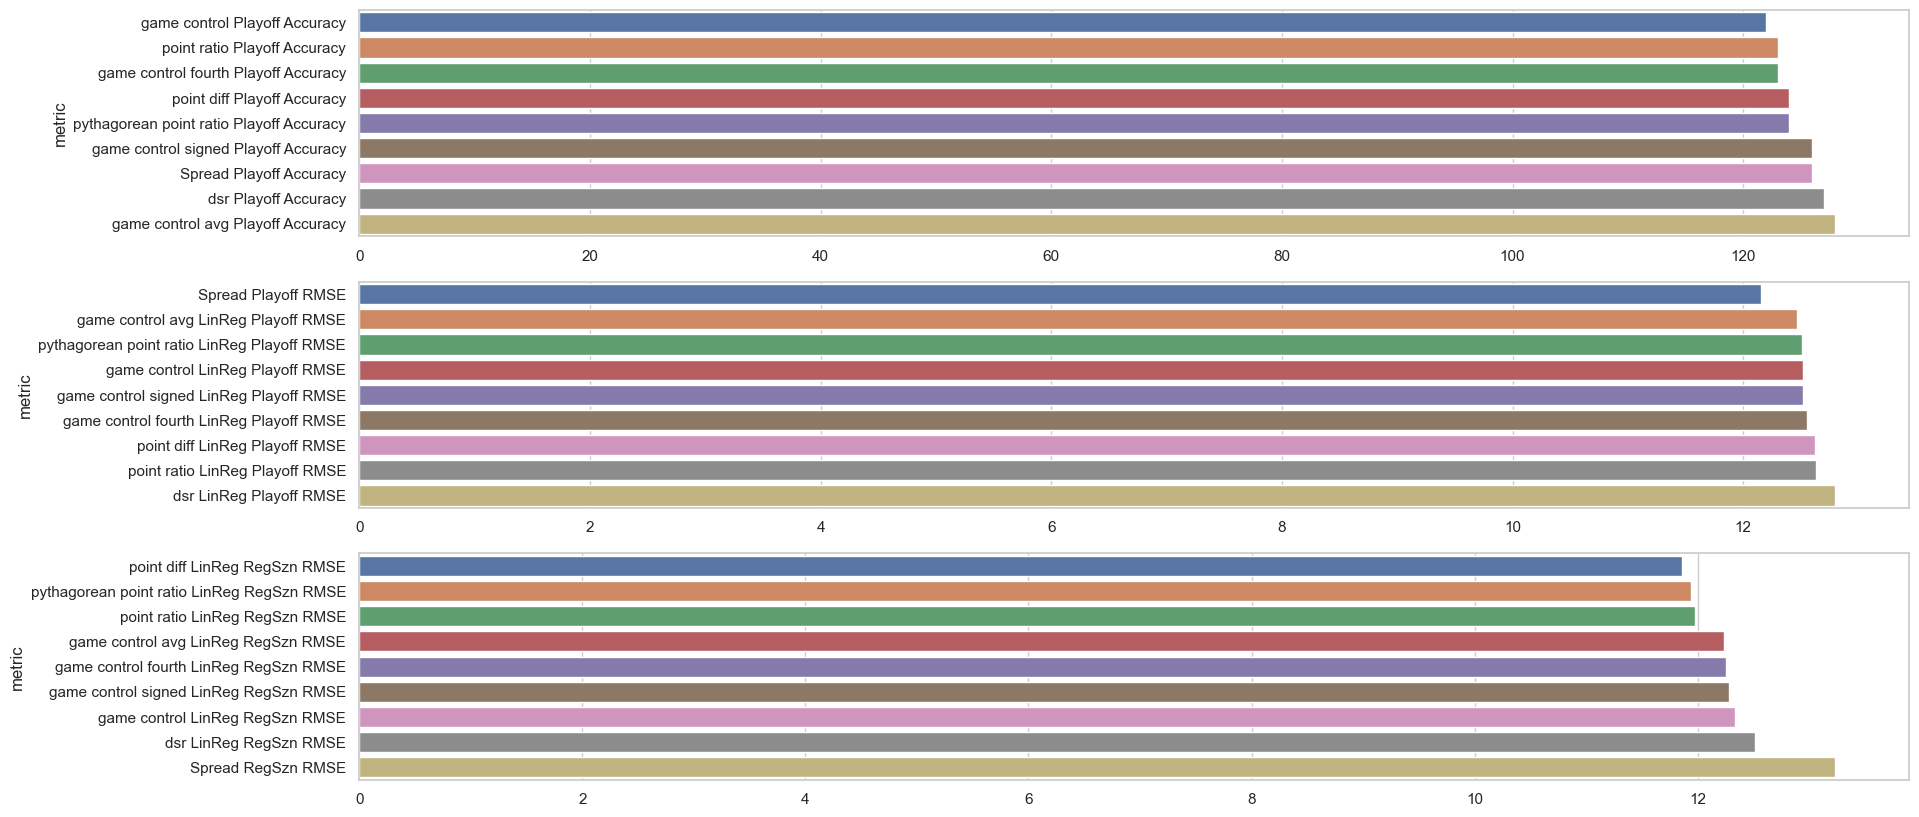

In [310]:
# plot results
fig1 = plt.figure(figsize=(20, 10))

plt.subplot(3, 1, 1)
sns.barplot(y=playoff_acc.index, x=playoff_acc*204)
plt.ylabel('metric')

plt.subplot(3, 1, 2)
sns.barplot(y=playoff_rmse.index, x=playoff_rmse)
plt.ylabel('metric')

plt.subplot(3, 1, 3)
sns.barplot(y=regszn_rmse.index, x=regszn_rmse)
plt.ylabel('metric')